## 1. Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

from classiq import *
from classiq.applications.iqae.iqae import IQAE

## 2. Discretize the return distribution

In [2]:
num_qubits = 9
N = 2**num_qubits

# Gaussian return distribution: R ~ Normal(mu, sigma)
mu, sigma = 0.15, 0.2

# Discretize support on [-L, L]
L = 4.0
grid_points = np.linspace(-L, L, N)

# Discrete probabilities from PDF
pdf = stats.norm.pdf(grid_points, loc=mu, scale=sigma)
probs = (pdf / pdf.sum()).tolist()

print("Sum(probs) =", sum(probs))
print("Grid range =", (grid_points.min(), grid_points.max()))

Sum(probs) = 1.0
Grid range = (np.float64(-4.0), np.float64(4.0))


### Visualize discretization

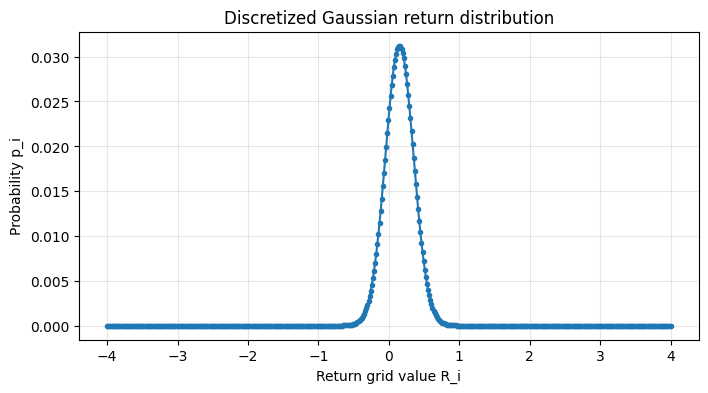

In [3]:
plt.figure(figsize=(8,4))
plt.plot(grid_points, probs, marker=".", linestyle="-")
plt.xlabel("Return grid value R_i")
plt.ylabel("Probability p_i")
plt.title("Discretized Gaussian return distribution")
plt.grid(True, alpha=0.3)
plt.show()

## 3. Loss definition + CVaR reweighted distribution


In [4]:
# For CVaR we need to estimate a *tail mean*.
# IQAE works with probabilities, so the weighting we use must be NON‑NEGATIVE.
#
# Returns R can be negative, so we map them to a non‑negative variable:
#   S = (R - Rmin) / (Rmax - Rmin)  in [0, 1]
#
# Then:
#   E[R | tail] = Rmin + (Rmax - Rmin) * E[S | tail]
#
# We'll estimate E[S | tail] via the usual "weighted distribution" trick.

R_min = float(grid_points.min())
R_max = float(grid_points.max())
R_span = R_max - R_min

s_grid = (grid_points - R_min) / R_span            # S_i in [0,1]
Z_s = float(np.dot(np.array(probs), s_grid))       # Z = E[S]

if Z_s == 0:
    raise ValueError("Z_s is zero. Adjust mu/sigma or grid.")

weighted_probs = (np.array(probs) * s_grid / Z_s).tolist()

print("Return range =", (R_min, R_max))
print("Z_s = E[S] =", Z_s)
print("Sum(weighted_probs) =", float(np.sum(weighted_probs)))


Return range = (-4.0, 4.0)
Z_s = E[S] = 0.51875
Sum(weighted_probs) = 1.0


## 4. Oracle: mark the left-tail event (asset ≤ index)




In [5]:
GLOBAL_INDEX = 0
ACTIVE_PROBS = None

@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(ACTIVE_PROBS, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset <= GLOBAL_INDEX

@qfunc(synthesize_separately=True)
def state_preparation(asset: QNum, ind: QBit):
    load_distribution(asset)
    payoff(asset, ind)

## 5. IQAE helpers



In [6]:
written_qprog = False

def iqae_estimate_tail_prob(index: int, eps=0.02, alpha_fail=0.01, use_weighted=False, show_qprog_once=True) -> float:
    global GLOBAL_INDEX, ACTIVE_PROBS, written_qprog

    GLOBAL_INDEX = int(index)
    ACTIVE_PROBS = weighted_probs if use_weighted else probs

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits),
    )

    if show_qprog_once and not written_qprog:
        written_qprog = True
        show(iqae.get_qprog())

    res = iqae.run(epsilon=eps, alpha=alpha_fail)
    est = float(res.estimation)
    L, U = res.confidence_interval
    print(f"IQAE({'weighted' if use_weighted else 'base'}) index={index}: est≈{est:.6f}, CI=[{L:.6f}, {U:.6f}]")
    return est


def iqae_cvar_loss_at_index(index: int, eps=0.02, alpha_fail=0.01):
    alpha_hat = iqae_estimate_tail_prob(index, eps=eps, alpha_fail=alpha_fail, use_weighted=False)
    beta_hat  = iqae_estimate_tail_prob(index, eps=eps, alpha_fail=alpha_fail, use_weighted=True)

    cvar_loss = (Z_loss * beta_hat) / max(alpha_hat, 1e-12)
    return float(cvar_loss), float(alpha_hat), float(beta_hat)

## 6. VaR via bisection on tail probability



In [7]:
def value_at_risk_bisection(alpha_target: float, alpha_func) -> int:
    low, high = 0, N - 1
    while low < high:
        mid = (low + high) // 2
        a_mid = alpha_func(mid)
        if a_mid >= alpha_target:
            high = mid
        else:
            low = mid + 1
    return int(low)

## 7. Classical baselines (discrete + theoretical Gaussian)

In [8]:
def gaussian_var_cvar_return(mu, sigma, conf_level):
    """(VaR_return, CVaR_return) for the LEFT tail alpha = 1 - conf_level.
    VaR_return is the alpha-quantile. CVaR_return = E[R | R <= VaR]."""
    alpha = 1 - conf_level
    z = stats.norm.ppf(alpha)
    var_return = mu + sigma * z
    phi = stats.norm.pdf(z)
    cvar_return = mu - sigma * (phi / alpha)
    return float(var_return), float(cvar_return)

def discrete_var_index(probs, alpha_tail):
    """Smallest index i such that sum_{k<=i} p_k >= alpha_tail."""
    acc = 0.0
    for idx, p in enumerate(probs):
        acc += p
        if acc >= alpha_tail:
            return idx
    return len(probs) - 1

def classical_cvar_return_discrete(var_index: int) -> float:
    """Discrete CVaR_return = E[R | R <= VaR_index]."""
    alpha = float(np.sum(probs[:var_index+1]))
    tail_sum = float(np.dot(np.array(probs[:var_index+1]), grid_points[:var_index+1]))
    return tail_sum / max(alpha, 1e-12)


## 8. Benchmark: confidence level → VaR and CVaR (only)



In [10]:
CONF_LEVELS = [0.90, 0.95, 0.975, 0.99]

EPS_BASE = 0.02
ALPHA_FAIL = 0.01

records = []

for conf_level in CONF_LEVELS:
    alpha_tail = 1 - conf_level
    print("\n" + "="*80)
    print(f"CONF_LEVEL={conf_level:.3f}  (left-tail alpha={alpha_tail:.5f})")

    # --- Adaptive Epsilon 
    # To avoid the spike, we need epsilon << alpha_tail.\n",
    # We set eps to be at most alpha_tail / 3 to ensure stability.\n",
    current_eps = min(EPS_BASE, alpha_tail / 3)

    print("\n" + "="*80)
    print(f"CONF_LEVEL={conf_level:.3f} -> Using epsilon={current_eps:.5f}")

    # --- theoretical (continuous Gaussian) ---
    var_th_ret, cvar_th_ret = gaussian_var_cvar_return(mu, sigma, conf_level)

    # --- discrete classical (same discretization as the quantum state) ---
    var_idx = discrete_var_index(probs, alpha_tail)
    var_disc_ret = float(grid_points[var_idx])
    cvar_disc_ret = classical_cvar_return_discrete(var_idx)

    # --- IQAE: tail probability P(R <= VaR_index) ---
    alpha_hat = iqae_estimate_tail_prob(var_idx, eps=EPS, alpha_fail=ALPHA_FAIL, use_weighted=False)

    # --- IQAE: numerator trick for the shifted variable S in [0,1]
    # P_weighted_tail = P_tail under distribution proportional to p_i * S_i
    p_weighted_tail = iqae_estimate_tail_prob(var_idx, eps=EPS, alpha_fail=ALPHA_FAIL, use_weighted=True, show_qprog_once=False)

    # E[S * 1_tail] = Z_s * P_weighted_tail
    ES_indicator = Z_s * p_weighted_tail

    # Conditional mean of S in the tail:
    # E[S | tail] = E[S*1_tail] / P(tail)
    mean_s_tail = ES_indicator / max(alpha_hat, 1e-12)

    # Convert back to returns:
    cvar_iqae_ret = R_min + R_span * mean_s_tail

    print(f"  theory VaR_return ≈ {var_th_ret:+.6f},  CVaR_return ≈ {cvar_th_ret:+.6f}")
    print(f"  discrete VaR_return≈ {var_disc_ret:+.6f}, CVaR_return≈ {cvar_disc_ret:+.6f}")
    print(f"  IQAE tail prob alpha_hat≈ {alpha_hat:.6f}")
    print(f"  IQAE CVaR_return ≈ {cvar_iqae_ret:+.6f}")

    records.append({
        "conf_level": conf_level,
        "alpha_tail": alpha_tail,
        "u_eps": current_eps,
        "VaR_theory_return": var_th_ret,
        "CVaR_theory_return": cvar_th_ret,
        "VaR_disc_return": var_disc_ret,
        "VaR_iqae_return": var_disc_ret,
        "CVaR_disc_return": cvar_disc_ret,
        "tail_prob_iqae": alpha_hat,
        "CVaR_iqae_return": cvar_iqae_ret,


    })

df = pd.DataFrame(records)
df



CONF_LEVEL=0.900  (left-tail alpha=0.10000)

CONF_LEVEL=0.900 -> Using epsilon=0.02000
Quantum program link: https://platform.classiq.io/circuit/393oW07feiwRcN91t0klJVJZKC5
IQAE(base) index=249: est≈0.110512, CI=[0.106828, 0.114196]
IQAE(weighted) index=249: est≈0.102973, CI=[0.099368, 0.106578]
  theory VaR_return ≈ -0.106310,  CVaR_return ≈ -0.200997
  discrete VaR_return≈ -0.101761, CVaR_return≈ -0.190889
  IQAE tail prob alpha_hat≈ 0.110512
  IQAE CVaR_return ≈ -0.133097

CONF_LEVEL=0.950  (left-tail alpha=0.05000)

CONF_LEVEL=0.950 -> Using epsilon=0.01667
IQAE(base) index=244: est≈0.054800, CI=[0.049485, 0.060114]
IQAE(weighted) index=244: est≈0.049730, CI=[0.045149, 0.054311]
  theory VaR_return ≈ -0.178971,  CVaR_return ≈ -0.262543
  discrete VaR_return≈ -0.180039, CVaR_return≈ -0.256900
  IQAE tail prob alpha_hat≈ 0.054800
  IQAE CVaR_return ≈ -0.233924

CONF_LEVEL=0.975  (left-tail alpha=0.02500)

CONF_LEVEL=0.975 -> Using epsilon=0.00833
IQAE(base) index=240: est≈0.027725, 

,conf_level,alpha_tail,u_eps,VaR_theory_return,CVaR_theory_return,VaR_disc_return,VaR_iqae_return,CVaR_disc_return,tail_prob_iqae,CVaR_iqae_return
0,0.900,0.100,0.020000,-0.106310,-0.200997,-0.101761,-0.101761,-0.190889,0.110512,-0.133097
1,0.950,0.050,0.016667,-0.178971,-0.262543,-0.180039,-0.180039,-0.256900,0.054800,-0.233924
2,0.975,0.025,0.008333,-0.241993,-0.317561,-0.242661,-0.242661,-0.311449,0.027725,-0.417452
3,0.990,0.010,0.003333,-0.315270,-0.383043,-0.320939,-0.320939,-0.381337,0.010493,-0.273492


## 9. Plots

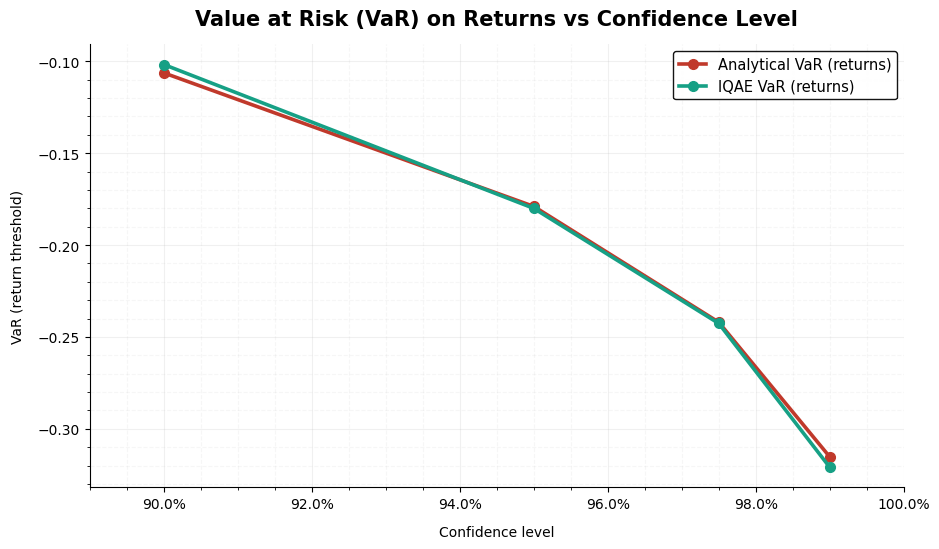

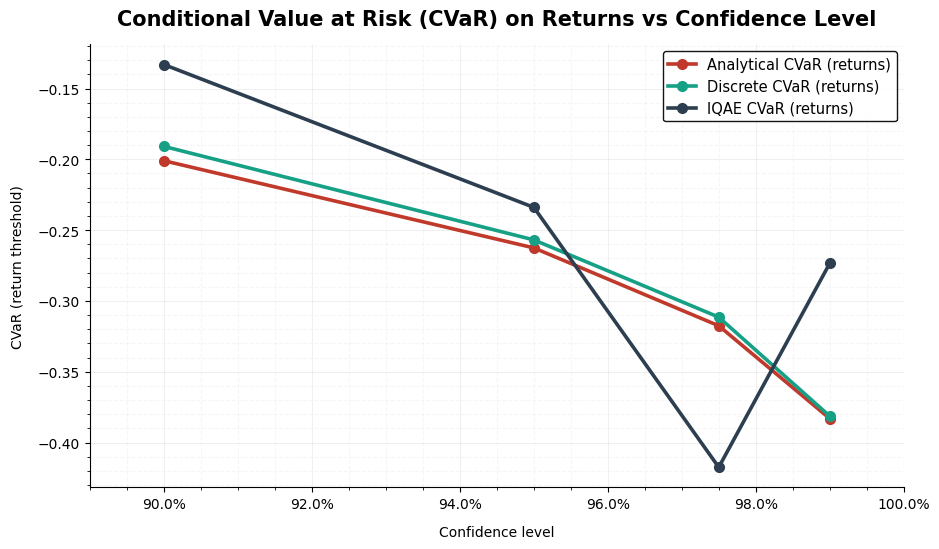

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(9.5, 5.6))

# Analytical VaR
ax.plot(
    df["conf_level"],
    df["VaR_theory_return"],
    marker="o",
    linewidth=2.6,
    markersize=7,
    color="#c0392b",
    label="Analytical VaR (returns)",
)

# IQAE VaR (if available)
if "VaR_iqae_return" in df.columns:
    ax.plot(
        df["conf_level"],
        df["VaR_iqae_return"],
        marker="o",
        linewidth=2.6,
        markersize=7,
        color="#16a085",
        label="IQAE VaR (returns)",
    )
else:
    ax.plot(
        df["conf_level"],
        [float("nan")] * len(df),
        marker="o",
        linewidth=2.6,
        markersize=7,
        color="#16a085",
        label="IQAE VaR (returns)",
    )

# Title (single, professional)
ax.set_title(
    "Value at Risk (VaR) on Returns vs Confidence Level",
    fontsize=15,
    fontweight="bold",
    pad=14,
)

# Axis labels
ax.set_xlabel("Confidence level", labelpad=10)
ax.set_ylabel("VaR (return threshold)", labelpad=10)

# Format x-axis as percentages
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlim(df["conf_level"].min() - 0.01, df["conf_level"].max() + 0.01)

# Clean grid
ax.grid(True, which="major", linestyle="-", alpha=0.18)
ax.grid(True, which="minor", linestyle="--", alpha=0.10)
ax.minorticks_on()

# Remove top/right spines for a modern look
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Legend
leg = ax.legend(frameon=True, framealpha=0.92, facecolor="white", edgecolor=(0, 0, 0, 0.08))
for text in leg.get_texts():
    text.set_fontsize(10.5)

fig.tight_layout()
plt.show()



import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(9.5, 5.6))

# CVaR theory
ax.plot(
    df["conf_level"],
    df["CVaR_theory_return"],
    marker="o",
    linewidth=2.6,
    markersize=7,
    color="#c0392b",
    label="Analytical CVaR (returns)",
)

# CVaR discrete
ax.plot(
    df["conf_level"],
    df["CVaR_disc_return"],
    marker="o",
    linewidth=2.6,
    markersize=7,
    color="#16a085",
    label="Discrete CVaR (returns)",
)

# CVaR IQAE
ax.plot(
    df["conf_level"],
    df["CVaR_iqae_return"],
    marker="o",
    linewidth=2.6,
    markersize=7,
    color="#2c3e50",  # navy blue
    label="IQAE CVaR (returns)",
)

# Title
ax.set_title(
    "Conditional Value at Risk (CVaR) on Returns vs Confidence Level",
    fontsize=15,
    fontweight="bold",
    pad=14,
)

# Axes
ax.set_xlabel("Confidence level", labelpad=10)
ax.set_ylabel("CVaR (return threshold)", labelpad=10)

# Percent formatting
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlim(df["conf_level"].min() - 0.01, df["conf_level"].max() + 0.01)

# Grid (light, professional)
ax.grid(True, which="major", linestyle="-", alpha=0.18)
ax.grid(True, which="minor", linestyle="--", alpha=0.10)
ax.minorticks_on()

# Clean spines
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# Legend
leg = ax.legend(frameon=True, framealpha=0.92, facecolor="white", edgecolor=(0, 0, 0, 0.08))
for text in leg.get_texts():
    text.set_fontsize(10.5)

fig.tight_layout()
plt.show()

